In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
import imshows
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2024-03-20 19:24:15,443	INFO worker.py:1636 -- Started a local Ray instance.


# SVC Plots

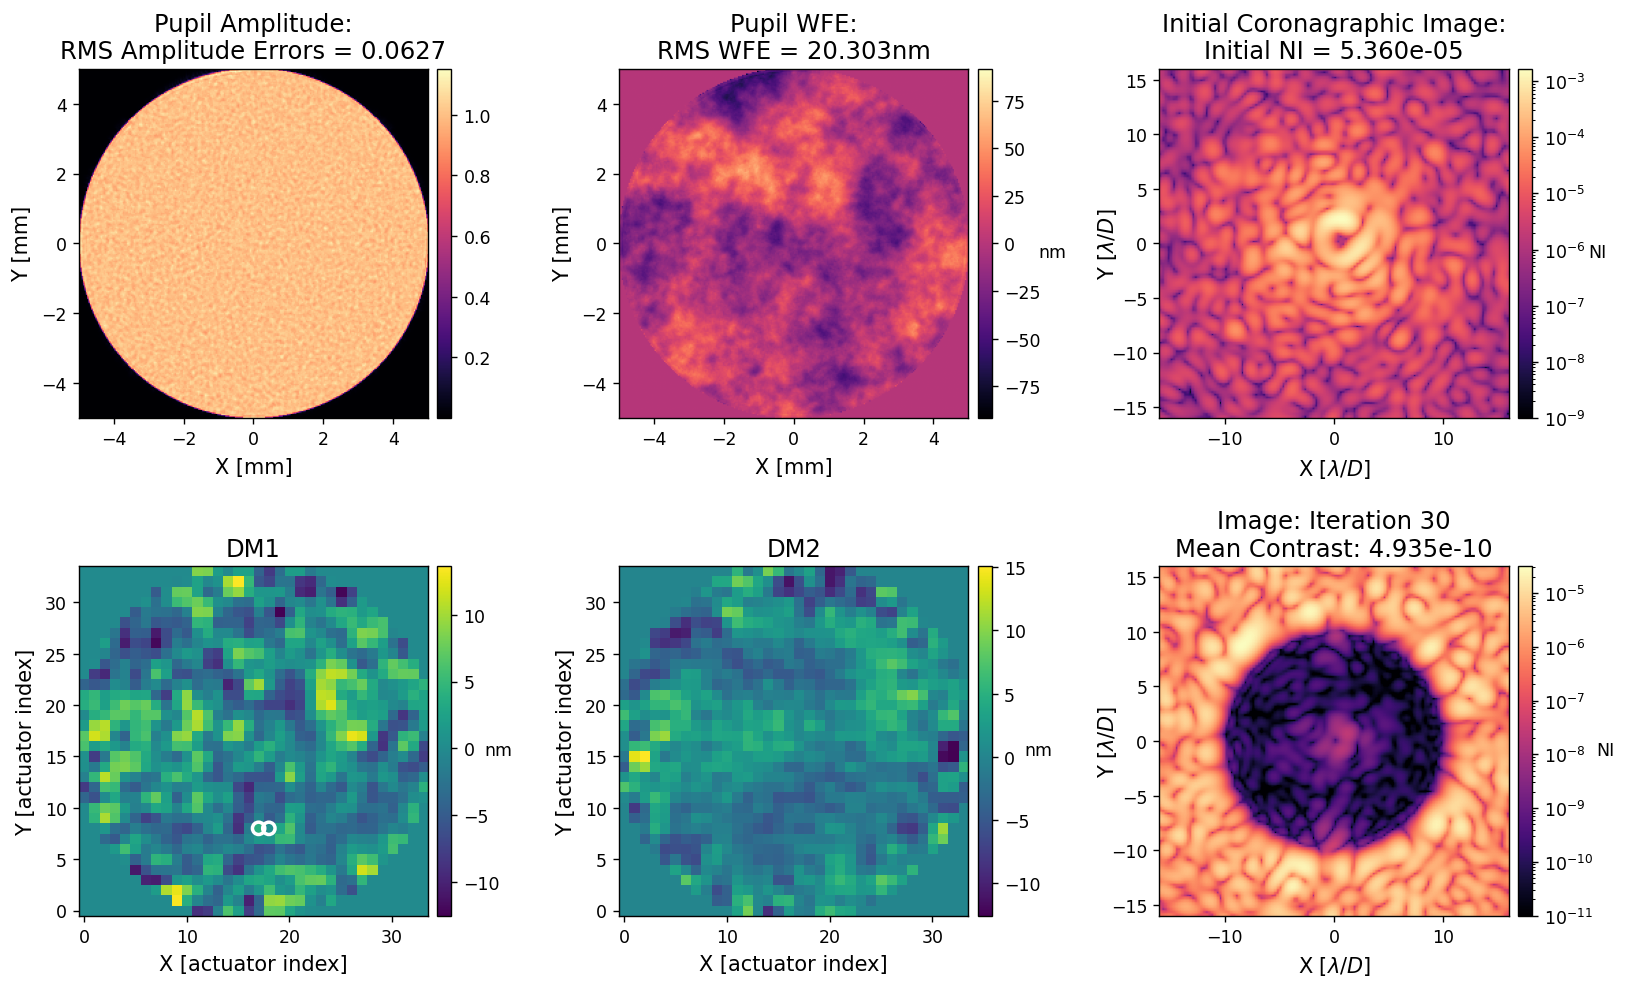

In [3]:
import hcipy_models as hcim
reload(hcim)
npix = 256
oversample = 2
svc = hcim.SVC(npix=npix, oversample=oversample, psf_pixelscale_lamD=1/4)
control_mask = ensure_np_array(utils.create_annular_focal_plane_mask(svc, inner_radius=2, outer_radius=10, edge=None, 
                                                                #      plot=True,
                                                                     ))

Nact = 34

pupil = fits.getdata('hcipy_svc_pupil.fits')
pupil_hdr = fits.getheader('hcipy_svc_pupil.fits')
pupil_pxscl = pupil_hdr['PIXELSCL']
rms_amp = pupil_hdr['RMSAMP']
rms_wfe = pupil_hdr['RMSWFE']
ref_im = fits.getdata('hcipy_svc_im.fits')

mean_ni_0 = np.mean(ref_im[control_mask])

date = 20231216
date = 20240130
date = 20240320
svc_dm1s = fits.getdata(response_dir/f'hcipy_svc_dm1_commands_{date}.fits')*1e9
svc_dm2s = fits.getdata(response_dir/f'hcipy_svc_dm2_commands_{date}.fits')*1e9
svc_images = fits.getdata(response_dir/f'hcipy_svc_images_{date}.fits')

i = 30
contrast = xp.mean(svc_images[i][control_mask])
probe_inds_1 = np.array([Nact//2, Nact//4])
probe_inds_2 = np.array([Nact//2+1, Nact//4])
patches = [Circle((probe_inds_1[0],probe_inds_1[1]), 0.6, color='w', fill=False, linewidth=2),
           Circle((probe_inds_2[0],probe_inds_2[1]), 0.6, color='w', fill=False, linewidth=2)]
dm_max = np.max(np.abs(np.concatenate([svc_dm1s[i], svc_dm2s[i]])))

fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15,9), dpi=125)

im1 = ax[0,0].imshow(pupil[0], cmap='magma', extent=[-5,5,-5,5])
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im1, cax=cax)

opd = pupil[1]*1e9
im2 = ax[0,1].imshow(opd, cmap='magma', extent=[-5,5,-5,5], vmin=-np.max(np.abs(opd)), vmax=np.max(np.abs(opd)) )
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im2, cax=cax,)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=7)

im3 = ax[0,2].imshow(ref_im, norm=LogNorm(vmin=1e-9), cmap='magma', extent=[-16,16,-16,16],)
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im3, cax=cax,)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)

im4 = ax[1,0].imshow(svc_dm1s[i])
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im4, cax=cax,)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=-1)

ax[1,0].add_patch(patches[0])
ax[1,0].add_patch(patches[1])

im5 = ax[1,1].imshow(svc_dm2s[i])
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im5, cax=cax,)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=-1)

im6 = ax[1,2].imshow(svc_images[i], norm=LogNorm(vmin=1e-11), cmap='magma',extent=[-16,16,-16,16],) 
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im6, cax=cax,)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)

ax[0,0].set_title(f'Pupil Amplitude:\nRMS Amplitude Errors = {rms_amp:.4f}', fontsize=14,)
ax[0,1].set_title(f'Pupil WFE:\nRMS WFE = {1e9*rms_wfe:.3f}nm', fontsize=14,)
ax[0,2].set_title(f'Initial Coronagraphic Image:\nInitial NI = {mean_ni_0:.3e}', fontsize=14,)
ax[1,0].set_title(f'DM1', fontsize=14,)
ax[1,1].set_title(f'DM2', fontsize=14,)
ax[1,2].set_title(f'Image: Iteration {i}\nMean Contrast: {contrast:.3e}', fontsize=14,)

ax[0,0].set_ylabel('Y [mm]', fontsize=12, labelpad=5)
ax[0,1].set_ylabel('Y [mm]', fontsize=12, labelpad=5)
ax[0,2].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[0,0].set_xlabel('X [mm]', fontsize=12, labelpad=5)
ax[0,1].set_xlabel('X [mm]', fontsize=12, labelpad=5)
ax[0,2].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)

ax[1,0].set_ylabel('Y [actuator index]', fontsize=12, labelpad=5)
ax[1,1].set_ylabel('Y [actuator index]', fontsize=12, labelpad=5)
ax[1,2].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[1,0].set_xlabel('X [actuator index]', fontsize=12, labelpad=5)
ax[1,1].set_xlabel('X [actuator index]', fontsize=12, labelpad=5)
ax[1,2].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)

plt.subplots_adjust(wspace=0.45, hspace=0.35)

fig.savefig('figs/hcipy_svc.pdf', format='pdf', bbox_inches="tight")




# POPPY Plots

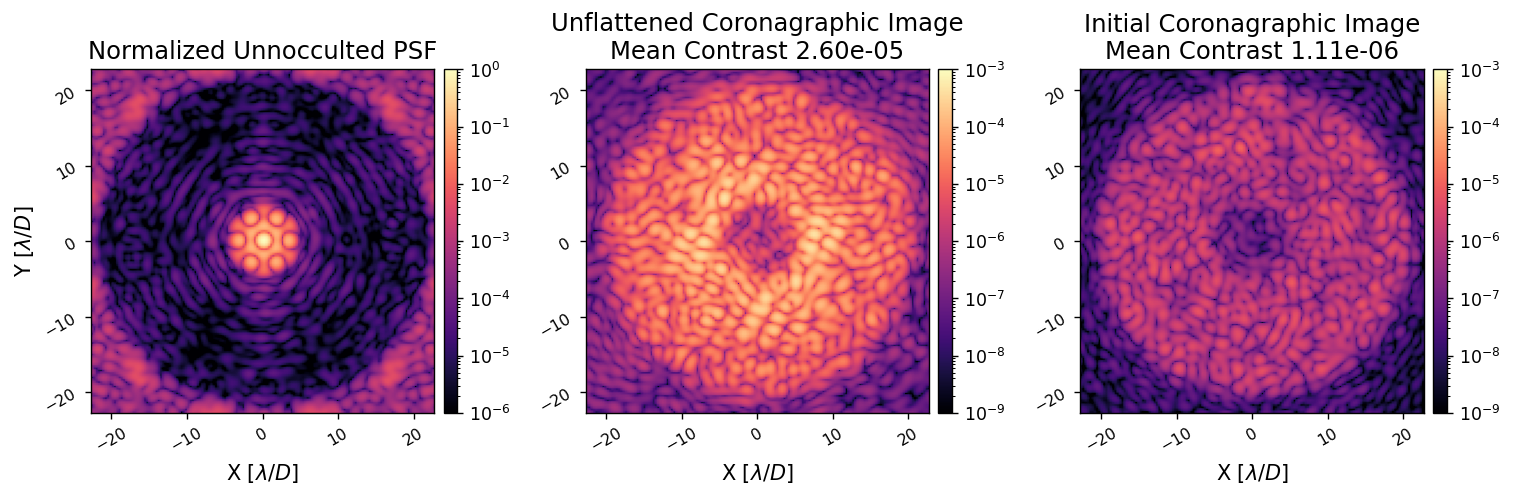

In [3]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                use_pupil_defocus=True, 
                                use_opds=True,
                                dm1_ref=2*dm1_flat, 
                                # dm2_ref=-dm2_flat,
                                )
mode.FPM.centerng = 'FFTSTYLE'

mode.use_fpm = False
psf = mode.snap()

mode.Imax_ref = xp.max(psf)
ref_psf = mode.snap()
mode.use_fpm = True

mode.set_dm1(np.zeros_like(dm1_flat))
mode.set_dm2(np.zeros_like(dm2_flat))
ref_im_bad = mode.snap()

mode.reset_dms()
ref_im = mode.snap()

reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, 
                                                    #  plot=True,
                                                     )
mean_ni_bad = xp.mean(ref_im_bad[control_mask])
mean_ni = xp.mean(ref_im[control_mask])

fig,ax = imshow3(ref_psf, ref_im_bad, ref_im,
                pxscl=mode.psf_pixelscale_lamD, 
                lognorm=True, vmin1=1e-6, vmax2=1e-3, vmax3=1e-3, vmin2=1e-9,  vmin3=1e-9,
                wspace=0.35,
                return_fig=True, display_fig=False)
ax[0].set_title('Normalized Unnocculted PSF', fontsize=14,)
ax[1].set_title(f'Unflattened Coronagraphic Image\nMean Contrast {mean_ni_bad:.2e}', fontsize=14,)
ax[2].set_title(f'Initial Coronagraphic Image\nMean Contrast {mean_ni:.2e}', fontsize=14,)
ax[0].set_ylabel('Y [$\lambda/D$]', fontsize=12)
ax[0].set_xlabel('X [$\lambda/D$]', fontsize=12)
ax[1].set_xlabel('X [$\lambda/D$]', fontsize=12)
ax[2].set_xlabel('X [$\lambda/D$]', fontsize=12)
fig.savefig('figs/spc_wide_initial_state.pdf', format='pdf', bbox_inches="tight")
display(fig)



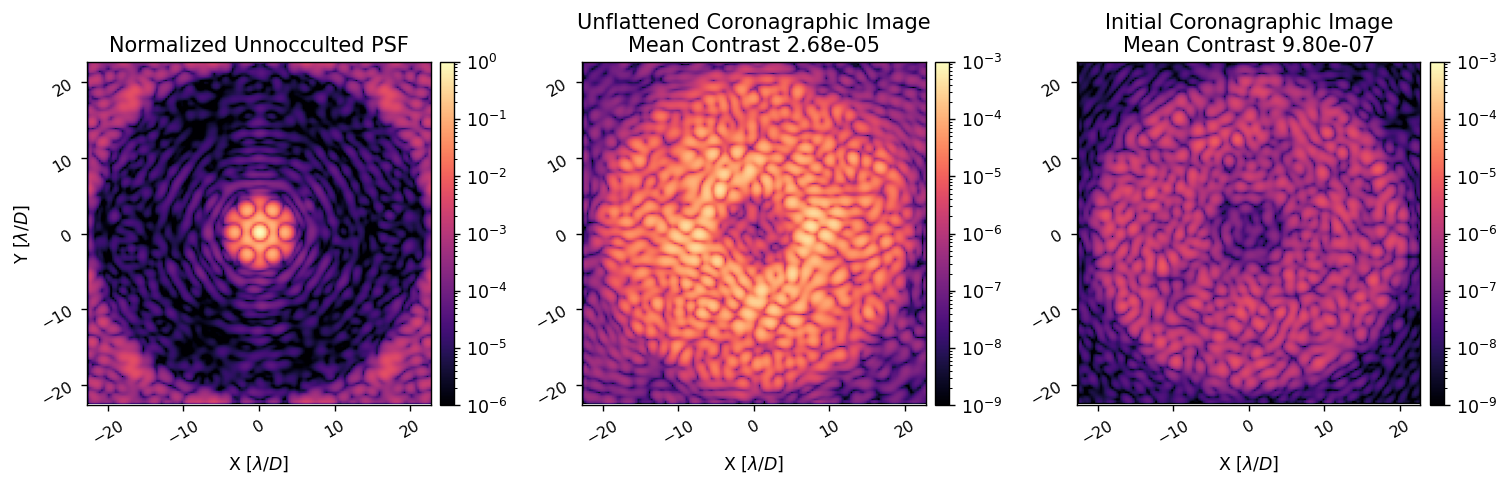

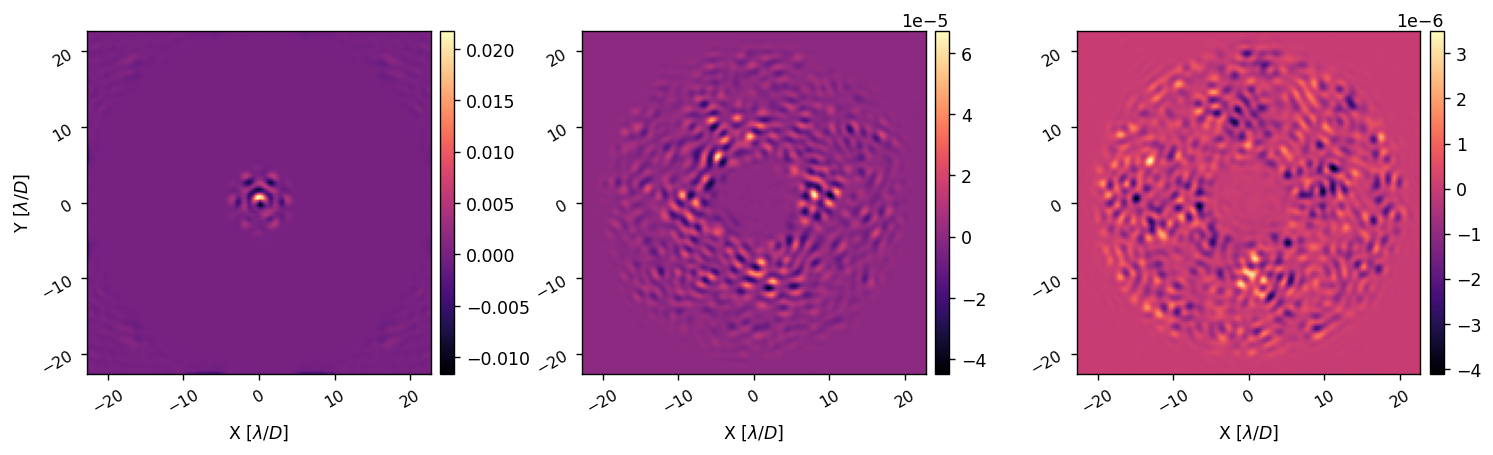

In [4]:
prop_ref_psf = scipy.ndimage.shift(np.rot90(np.rot90(fits.getdata('proper_spc_wide_flattened_psf.fits'))), (1,1))
prop_ref_im_bad = scipy.ndimage.shift(np.rot90(np.rot90(fits.getdata('proper_spc_wide_flattened_image_bad.fits'))), (1,1))
prop_ref_im = scipy.ndimage.shift(np.rot90(np.rot90(fits.getdata('proper_spc_wide_flattened_image.fits'))), (1,1))

prop_mean_ni_psf = np.mean(prop_ref_psf[ensure_np_array(control_mask)])
prop_mean_ni_bad = np.mean(prop_ref_im_bad[ensure_np_array(control_mask)])
prop_mean_ni = np.mean(prop_ref_im[ensure_np_array(control_mask)])

fig,ax = imshow3(prop_ref_psf, prop_ref_im_bad, prop_ref_im,
                 'Normalized Unnocculted PSF', 
                 f'Unflattened Coronagraphic Image\nMean Contrast {prop_mean_ni_bad:.2e}',
                 f'Initial Coronagraphic Image\nMean Contrast {prop_mean_ni:.2e}',
                pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]',
                lognorm=True, vmin1=1e-6, vmax2=1e-3, vmax3=1e-3, vmin2=1e-9,  vmin3=1e-9,
                wspace=0.35,
                return_fig=True, display_fig=False)
ax[0].set_ylabel('Y [$\lambda/D$]', )
# fig.savefig('figs/spc_wfov_initial_state.pdf', format='pdf', bbox_inches="tight")
display(fig)


psf_diff = prop_ref_psf-ensure_np_array(ref_psf)
bad_im_diff = prop_ref_im_bad-ensure_np_array(ref_im_bad)
flat_im_diff = prop_ref_im-ensure_np_array(ref_im)
fig,ax = imshow3(psf_diff, bad_im_diff, flat_im_diff,
                pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]',
                # lognorm=True, vmin1=1e-6, vmax2=1e-3, vmax3=1e-3, vmin2=1e-9,  vmin3=1e-9,
                wspace=0.35,
                return_fig=True, display_fig=False)
ax[0].set_ylabel('Y [$\lambda/D$]', )
display(fig)

In [9]:
mean_ni_psf = xp.mean(ref_psf)
mean_ni_bad = xp.mean(ref_im_bad)
mean_ni = xp.mean(ref_im)

prop_mean_ni_psf = np.mean(prop_ref_psf)
prop_mean_ni_bad = np.mean(prop_ref_im_bad)
prop_mean_ni = np.mean(prop_ref_im)

err_psf = (prop_mean_ni_psf-mean_ni_psf)/mean_ni_psf
err = (prop_mean_ni_bad - mean_ni_bad)/prop_mean_ni_bad
err_flat = (prop_mean_ni - mean_ni)/prop_mean_ni
print(err_psf*100, err*100, err_flat*100)

0.18416136902414337 2.968079395265132 -12.528262553827915


In [8]:
rms_diff_psf = np.sqrt(np.mean(np.square(psf_diff)))
rms_diff_im_bad = np.sqrt(np.mean(np.square(bad_im_diff)))
rms_diff_im_flat = np.sqrt(np.mean(np.square(flat_im_diff)))
print(rms_diff_psf, rms_diff_im_bad, rms_diff_im_flat)

0.0006101966012741255 5.78056073966651e-06 5.11906184307811e-07


In [39]:
np.mean(psf_diff/prop_ref_psf)

-inf

# EFC plots

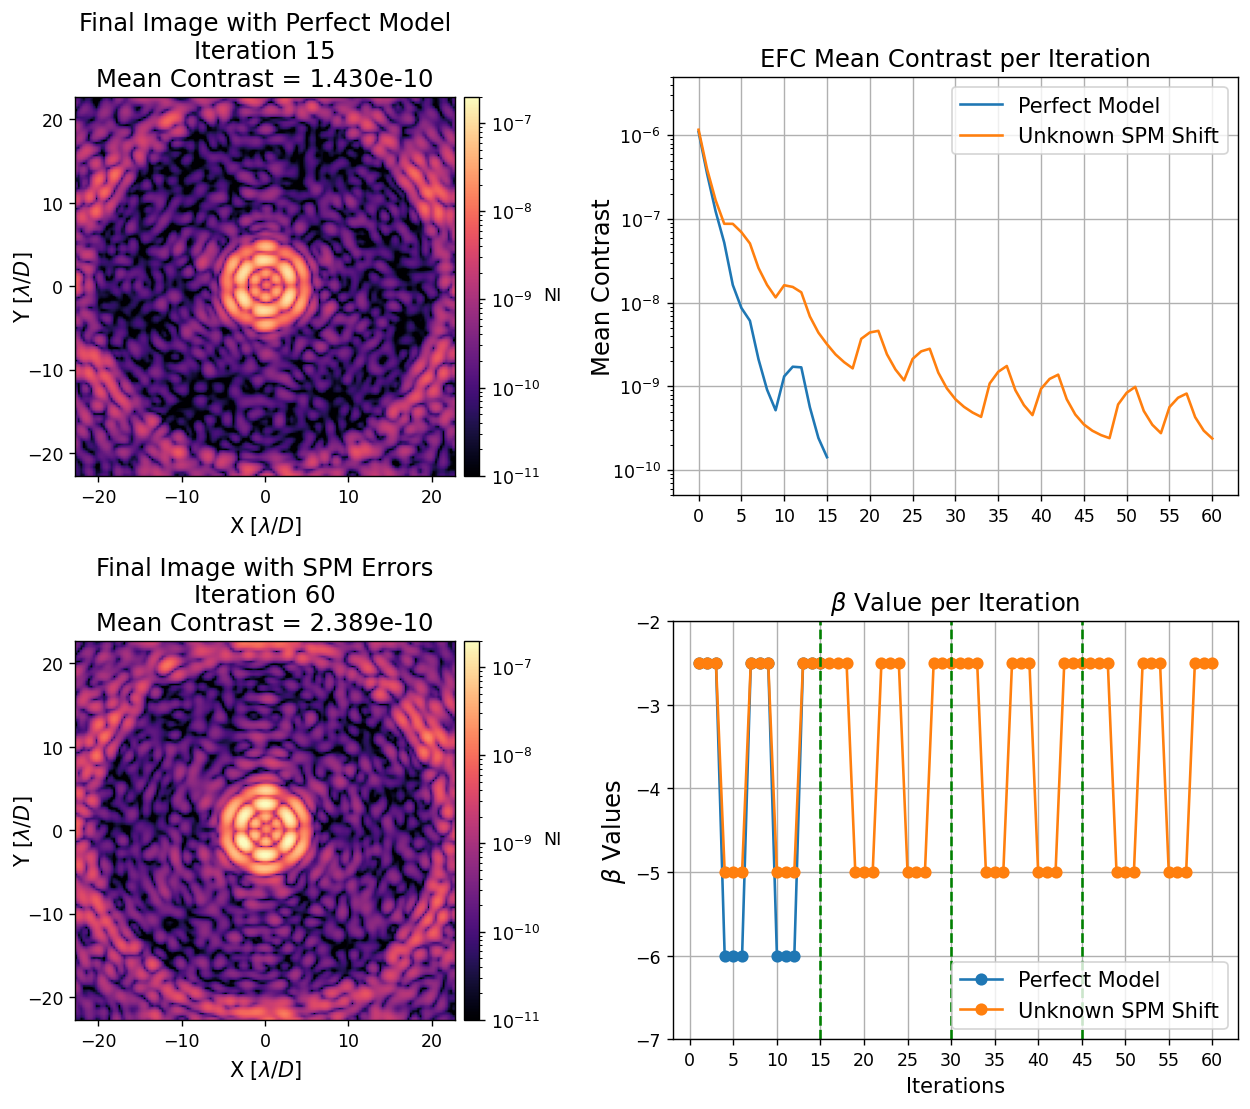

In [4]:
date = 20240117
date = 20240130
date = 20240201
images_perfect = fits.getdata(response_dir/f'efc_perfect_images_{date}.fits')
regs_perfect = fits.getdata(response_dir/f'efc_perfect_regs_{date}.fits')
nis_perfect = np.zeros(len(images_perfect))
for i in range(len(images_perfect)):
    nis_perfect[i] = np.mean(images_perfect[i][ensure_np_array(control_mask)])

date = 20240119
date = 20240130
date = 20240201
images_dm_spm5_shifts = fits.getdata(response_dir/f'efc_spm5_60_images_{date}.fits')
regs_dm_spm5_shifts = fits.getdata(response_dir/f'efc_spm5_60_regs_{date}.fits')
nis_dm_spm5_shifts = np.zeros(len(images_dm_spm5_shifts))
for i in range(len(images_dm_spm5_shifts)):
    nis_dm_spm5_shifts[i] = np.mean(images_dm_spm5_shifts[i][ensure_np_array(control_mask)])


fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10), dpi=125, gridspec_kw={'width_ratios': [1, 1.4]})
ext = mode.psf_pixelscale_lamD*150/2
extent = [-ext, ext, -ext, ext]

im1 = ax[0,0].imshow(images_perfect[-1], norm=LogNorm(vmax=2e-7, vmin=1e-11), cmap='magma', extent=extent)
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)
ax[0,0].set_title(f'Final Image with Perfect Model\nIteration 15\nMean Contrast = {nis_perfect[-1]:.3e}', fontsize=14)

im2 = ax[1,0].imshow(images_dm_spm5_shifts[-1], norm=LogNorm(vmax=2e-7, vmin=1e-11), cmap='magma', extent=extent)
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im2, cax=cax,)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)
ax[1,0].set_title(f'Final Image with SPM Errors\nIteration 60\nMean Contrast = {nis_dm_spm5_shifts[-1]:.3e}', fontsize=14)

ax[0,0].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[0,0].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)
ax[1,0].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[1,0].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)

ax[0,1].set_title('EFC Mean Contrast per Iteration', fontsize=14)
ax[0,1].semilogy(range(len(images_perfect)), nis_perfect, label='Perfect Model')
ax[0,1].semilogy(range(len(images_dm_spm5_shifts)), nis_dm_spm5_shifts, label='Unknown SPM Shift')
ax[0,1].grid()
ax[0,1].set_ylabel('Mean Contrast', fontsize=14, labelpad=-2)
ax[0,1].set_ylim([5e-11, 5e-6])
ax[0,1].set_xticks(np.arange(0,60+1, 5))
ax[0,1].legend(loc='upper right', fontsize=12)

ax[1,1].set_title('$\\beta$ Value per Iteration', fontsize=14)
ax[1,1].set_title('$\\beta$ Value per Iteration', fontsize=14)
ax[1,1].set_ylabel('$\\beta$ Values', fontsize=14)
ax[1,1].plot(range(len(images_perfect))[1:], regs_perfect, '-o', color='#1f77b4', label='Perfect Model')
ax[1,1].plot(range(len(images_dm_spm5_shifts))[1:], regs_dm_spm5_shifts, '-o', color='#ff7f0e', label='Unknown SPM Shift')
ax[1,1].vlines([15,30,45], ymin=-7, ymax=-2, linestyles='--', color='green')
ax[1,1].tick_params(axis ='y',)
ax[1,1].set_ylim([-7, -2])
ax[1,1].set_xticks(np.arange(0,60+1, 5))
# ax2.legend(bbox_to_anchor=(1.5, 0.5))
ax[1,1].legend(loc='lower right', fontsize=12)
ax[1,1].grid()
ax[1,1].set_xlabel('Iterations', fontsize=12)

plt.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('figs/efc_plots.pdf', format='pdf', bbox_inches="tight")



# iEFC Plots

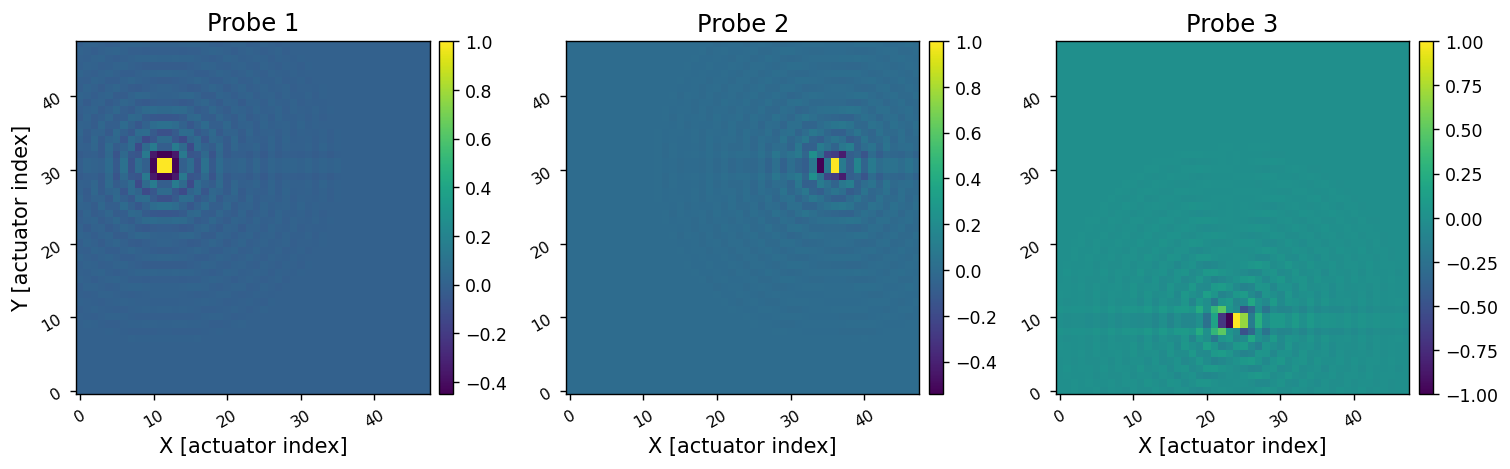

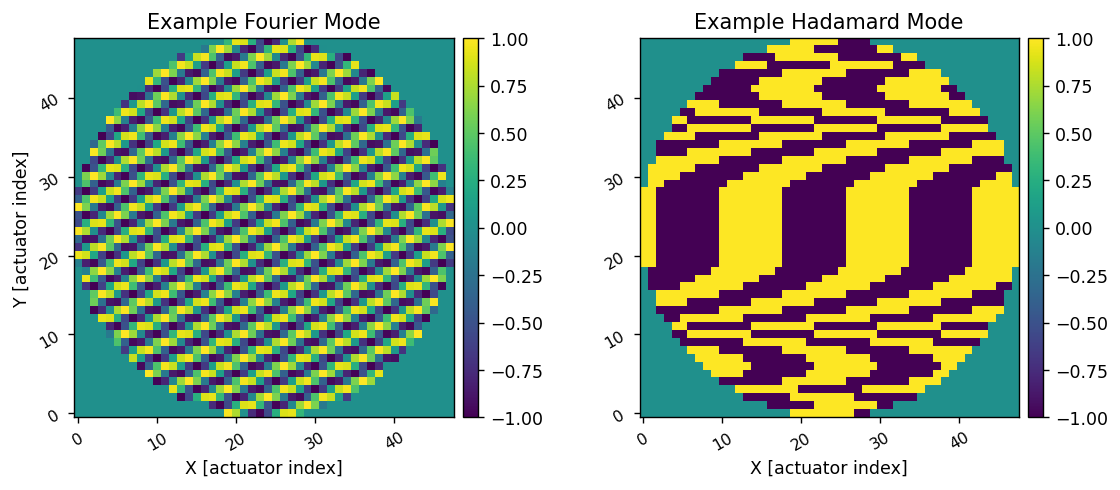

In [5]:
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.25,
                                          shift=[(-12,7), (12,7),(0,-14)], nprobes=3,
                                          use_weighting=True)
fig,ax = imshow3(probe_modes[0], probe_modes[1], probe_modes[2], 
                 'Probe 1', 'Probe 2', 'Probe 3',
                 cmap1='viridis', cmap2='viridis', cmap3='viridis',
                 display_fig=False, return_fig=True)
ax[0].set_title('Probe 1', fontsize=14)
ax[1].set_title('Probe 2', fontsize=14)
ax[2].set_title('Probe 3', fontsize=14)
ax[0].set_ylabel('Y [actuator index]', fontsize=12)
ax[0].set_xlabel('X [actuator index]', fontsize=12)
ax[1].set_xlabel('X [actuator index]', fontsize=12)
ax[2].set_xlabel('X [actuator index]', fontsize=12)

fig.savefig('figs/example_probes.pdf', format='pdf', bbox_inches="tight")
display(fig)

had_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=1)
hi = 8
fourier_modes = utils.create_fourier_modes(mode, control_mask, fourier_sampling=1, ndms=1)
fi = 108

probe_1_ind = tuple(np.roll(np.argwhere(probe_modes[0])[0],1))
probe_2_ind = tuple(np.roll(np.argwhere(probe_modes[1])[0],1))
probe_3_ind = tuple(np.roll(np.argwhere(probe_modes[2])[0],1))
patches1 = [Circle(probe_1_ind, 1, color='red'), Circle(probe_2_ind, 1, color='red'), Circle(probe_3_ind, 1, color='red')]
patches2 = [Circle(probe_1_ind, 1, color='red'), Circle(probe_2_ind, 1, color='red'), Circle(probe_3_ind, 1, color='red')]

fig,ax = imshow2(fourier_modes[fi].reshape(mode.Nact,mode.Nact), had_modes[hi].reshape(mode.Nact,mode.Nact),
        'Example Fourier Mode', 'Example Hadamard Mode', 
        xlabel='X [actuator index]',
        cmap1='viridis', cmap2='viridis', 
        # patches1=patches1, 
        # patches2=patches2,
        wspace=0.4,
        return_fig=True, display_fig=False,
        )
ax[0].set_ylabel('Y [actuator index]')
# ax[1].set_ylabel('Y [actuator index]')
fig.savefig('figs/example_modes.pdf', format='pdf', bbox_inches="tight")
display(fig)



In [20]:
had_modes.shape

(2048, 2304)

4.4695895495036345e-10


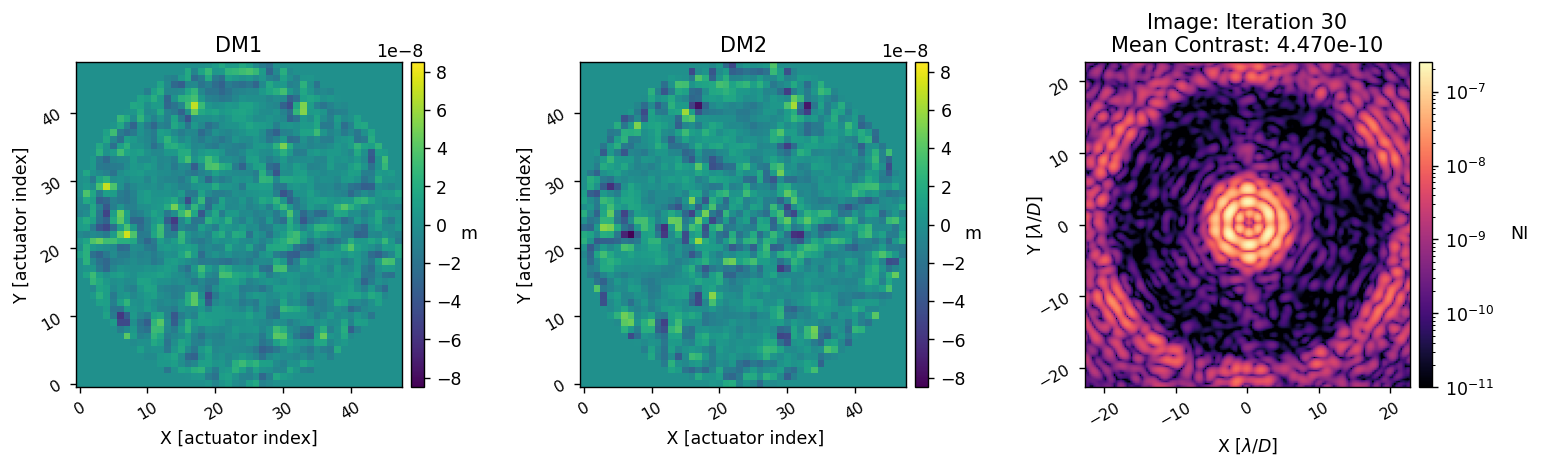

In [6]:
date = 20240207
dm1s = fits.getdata(response_dir/f'spc_small_fourier_modes_dm1_commands_{date}.fits') - 2*dm1_flat
dm2s = fits.getdata(response_dir/f'spc_small_fourier_modes_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_small_fourier_modes_images_{date}.fits')

fourier_regs = fits.getdata(response_dir/f'spc_small_fourier_modes_regs_{date}.fits')

fourier_small_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(fourier_small_contrast)
print(fourier_small_contrast[i])
fourier_im_small = ims[i]

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9

fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {fourier_small_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('figs/spc_iefc_fourier_small.pdf', format='pdf', bbox_inches="tight")
display(fig)

2.0826068877924508e-10


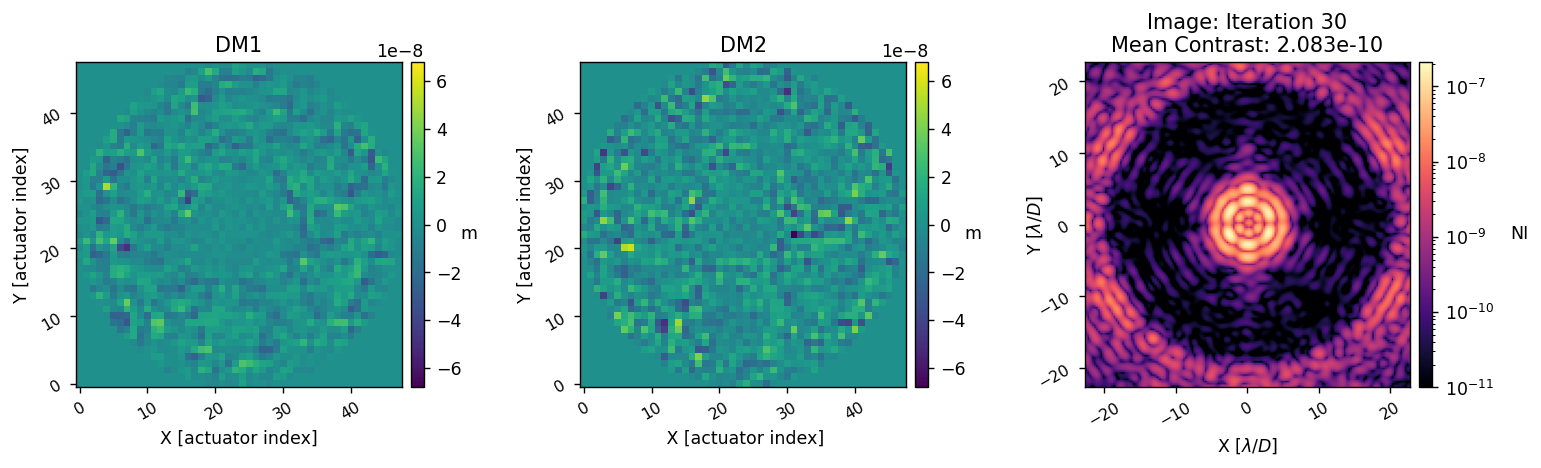

In [7]:
date = 20230926
date = 20231013
date = 20240130
date = 20240131
dm1s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_dm1_commands_{date}.fits') - 2*dm1_flat
dm2s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_images_{date}.fits')


fourier_regs = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_regs_{date}.fits')

fourier_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)
fourier_contrast.shape

i = np.argmin(fourier_contrast)
print(fourier_contrast[i])
fourier_im = ims[i]

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {fourier_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('figs/spc_iefc_fourier_large.pdf', format='pdf', bbox_inches="tight")
display(fig)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

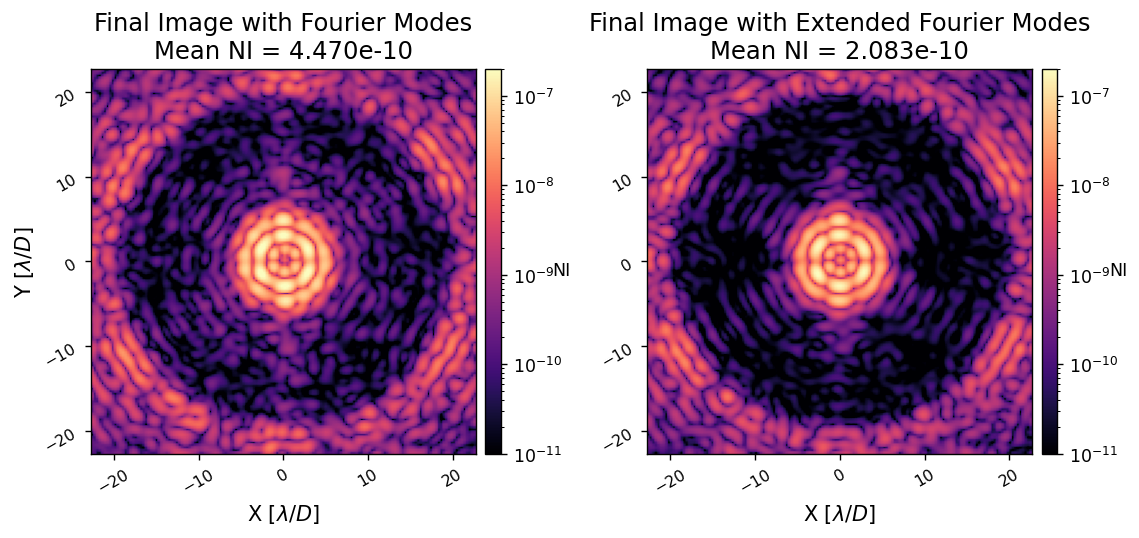

In [8]:
fig,ax = imshow2(fourier_im_small, fourier_im,
                 f'Final Image with Fourier Modes\nMean NI = {fourier_small_contrast[-1]:.3e}', 
                 f'Final Image with Extended Fourier Modes\nMean NI = {fourier_contrast[i]:.3e}',
                 lognorm=True, vmax1=2e-7, vmin1=1e-11, vmax2=2e-7, vmin2=1e-11,
                 cbar1_label='NI', cbar2_label='NI',
                 pxscl=mode.psf_pixelscale_lamD,  xlabel='X [$\lambda/D$]',
                 wspace=0.35, 
                 display_fig=False, return_fig=True)
ax[0].title.set_size(14)
ax[1].title.set_size(14)
ax[0].set_ylabel('Y [$\lambda/D$]', fontsize=12)
ax[0].set_xlabel('X [$\lambda/D$]', fontsize=12)
ax[1].set_xlabel('X [$\lambda/D$]', fontsize=12)
fig.savefig('figs/iefc_fourier_images.pdf', format='pdf', bbox_inches="tight")
display(fig)

1.8536231996257694e-10


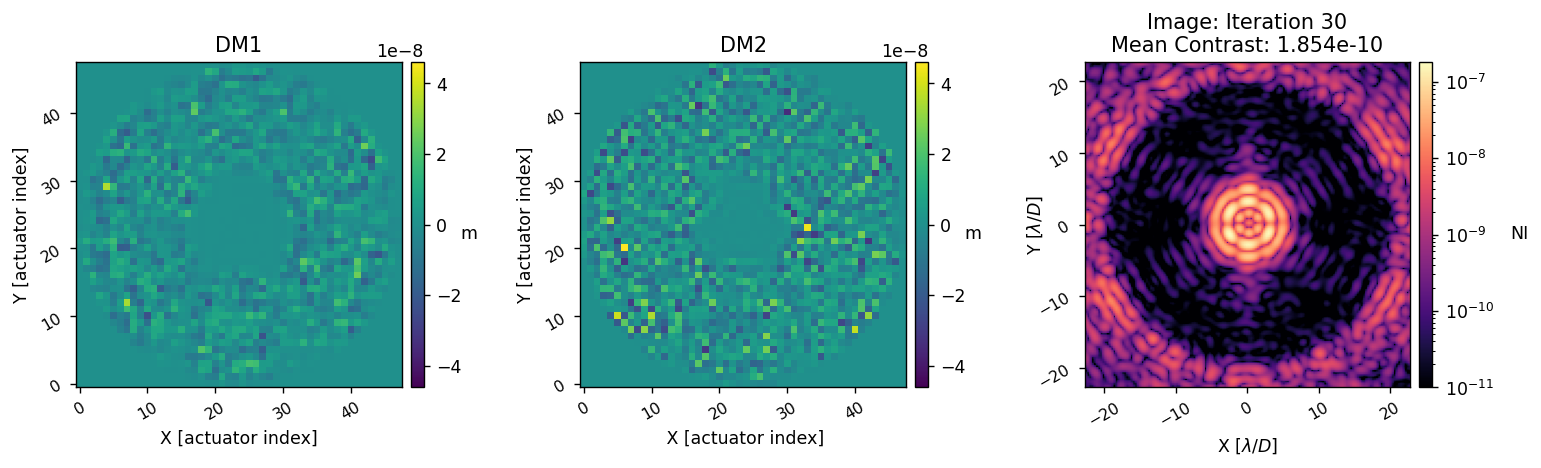

In [9]:
date = 20230921
date = 20231013
date = 20240130
date = 20240131
dm1s = fits.getdata(response_dir/f'spc_wfov_825_poke_dm1_commands_{date}.fits')  - 2*dm1_flat
dm2s = fits.getdata(response_dir/f'spc_wfov_825_poke_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_poke_images_{date}.fits')

poke_regs = fits.getdata(response_dir/f'spc_wfov_825_poke_regs_{date}.fits')

poke_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(poke_contrast)
print(poke_contrast[i])
poke_im = ims[i]

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {poke_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('figs/spc_iefc_pokes.pdf', format='pdf', bbox_inches="tight")
display(fig)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

1.1058529141546437e-10


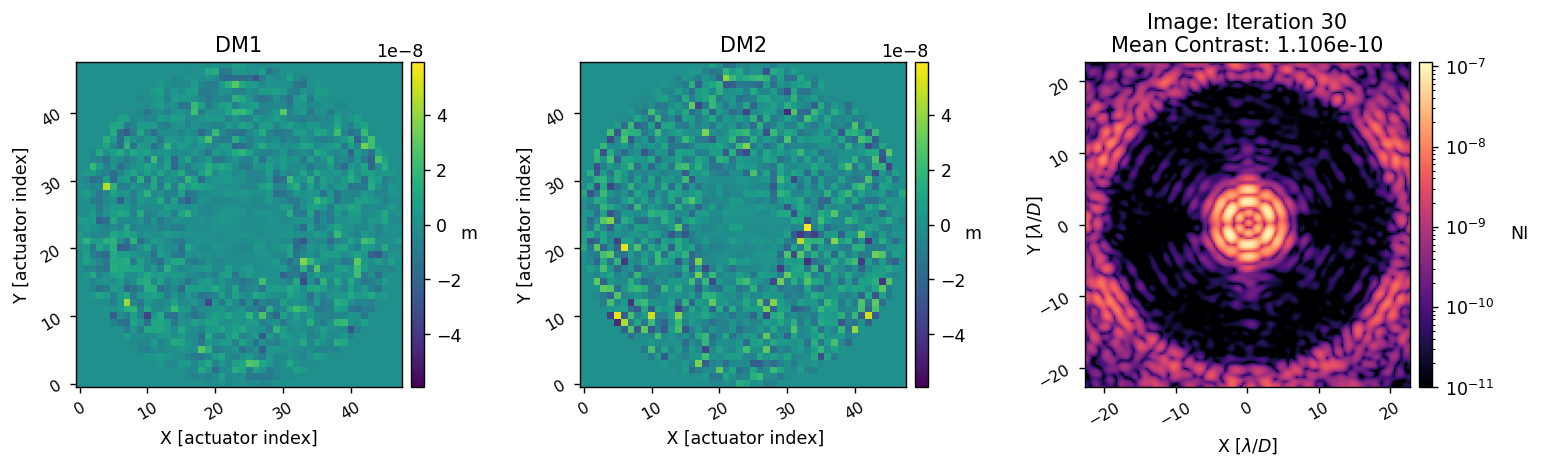

In [10]:
date = 20230925
date = 20231013
date = 20240130
date = 20240131
dm1s = fits.getdata(response_dir/f'spc_wfov_825_had_dm1_commands_{date}.fits')  - 2*dm1_flat
dm2s = fits.getdata(response_dir/f'spc_wfov_825_had_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_had_images_{date}.fits')
had_regs = fits.getdata(response_dir/f'spc_wfov_825_had_regs_{date}.fits')

had_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(had_contrast)
print(had_contrast[i])
had_im = ims[i]

dm_max = np.max(np.abs(np.concatenate([dm1s[i], dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i], dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        f'Image: Iteration {i}\nMean Contrast: {had_contrast[i]:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_ylabel('Y [actuator index]', labelpad=5)
ax[1].set_ylabel('Y [actuator index]', labelpad=5)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('figs/spc_iefc_hadamard.pdf', format='pdf', bbox_inches="tight")
display(fig)
# utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)




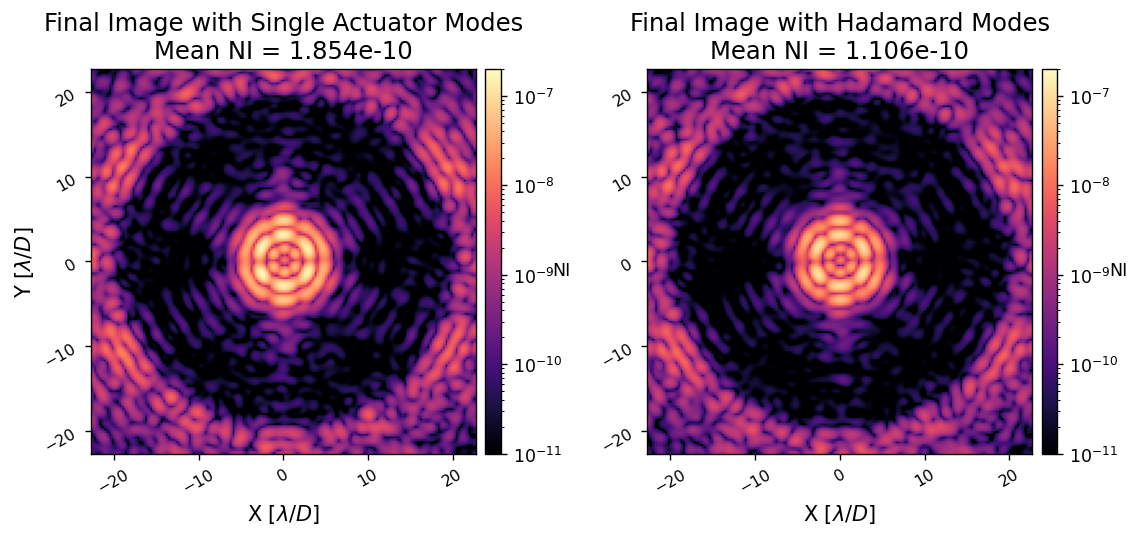

In [11]:
fig,ax = imshow2(poke_im, had_im,
                 f'Final Image with Single Actuator Modes\nMean NI = {poke_contrast[-1]:.3e}', 
                 f'Final Image with Hadamard Modes\nMean NI = {had_contrast[i]:.3e}',
                 lognorm=True, vmax1=2e-7, vmin1=1e-11, vmax2=2e-7, vmin2=1e-11,
                 cbar1_label='NI', cbar2_label='NI',
                 pxscl=mode.psf_pixelscale_lamD,  xlabel='X [$\lambda/D$]',
                 wspace=0.35, 
                 display_fig=False, return_fig=True)
ax[0].title.set_size(14)
ax[1].title.set_size(14)
ax[0].set_ylabel('Y [$\lambda/D$]', fontsize=12)
ax[0].set_xlabel('X [$\lambda/D$]', fontsize=12)
ax[1].set_xlabel('X [$\lambda/D$]', fontsize=12)
fig.savefig('figs/iefc_poke_had_images.pdf', format='pdf', bbox_inches="tight")
display(fig)

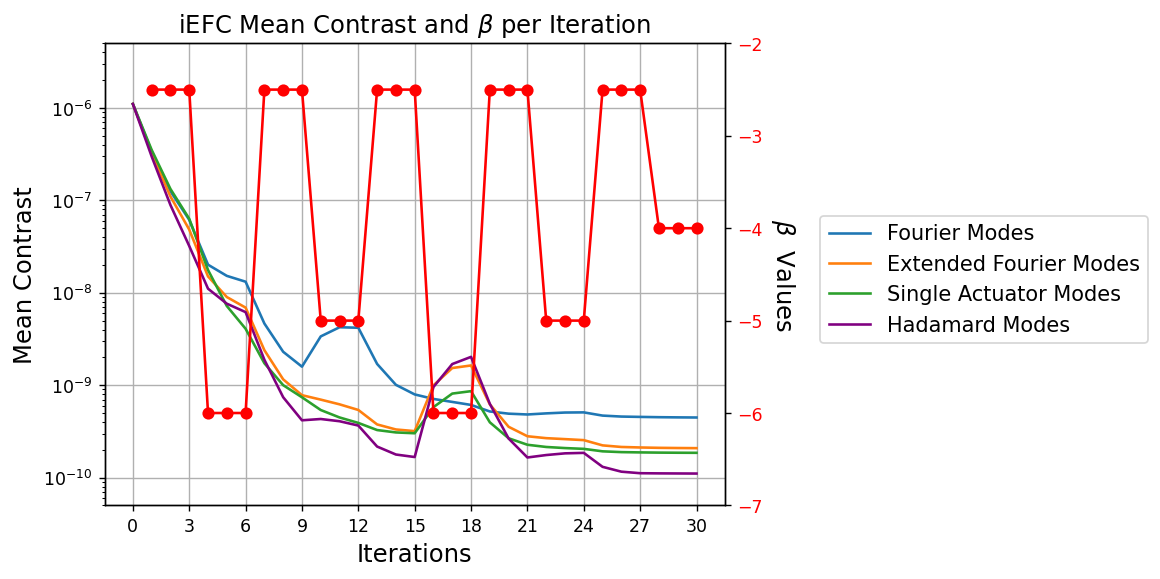

In [12]:
import matplotlib.pyplot as plt

itrs = range(fourier_contrast.shape[0])

fig,ax1 = plt.subplots(dpi=125)
ax1.semilogy(itrs, fourier_small_contrast, label='Fourier Modes')
ax1.semilogy(itrs, fourier_contrast, label='Extended Fourier Modes')
ax1.semilogy(itrs, poke_contrast, label='Single Actuator Modes')
ax1.semilogy(itrs, had_contrast, label='Hadamard Modes', color='purple')
ax1.set_xlabel('Iterations', fontsize=14, )
ax1.set_ylabel('Mean Contrast', fontsize=14,)
ax1.set_ylim([5e-11, 5e-6])
ax1.set_xticks(np.arange(0,30+1, 3))
# ax1.legend()
ax1.set_title('iEFC Mean Contrast and $\\beta$ per Iteration', fontsize=14)
ax1.legend(bbox_to_anchor=(1.7, 0.65), fontsize=12)
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel('$\\beta$  Values', fontsize=14, rotation=-90, labelpad = 20)
ax2.plot(itrs[1:], poke_regs, '-o', color='red',)
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.set_ylim([-7, -2])
plt.savefig('figs/iefc_mode_comp_plots.pdf', format='pdf', bbox_inches="tight")



1.325156195994803e-10


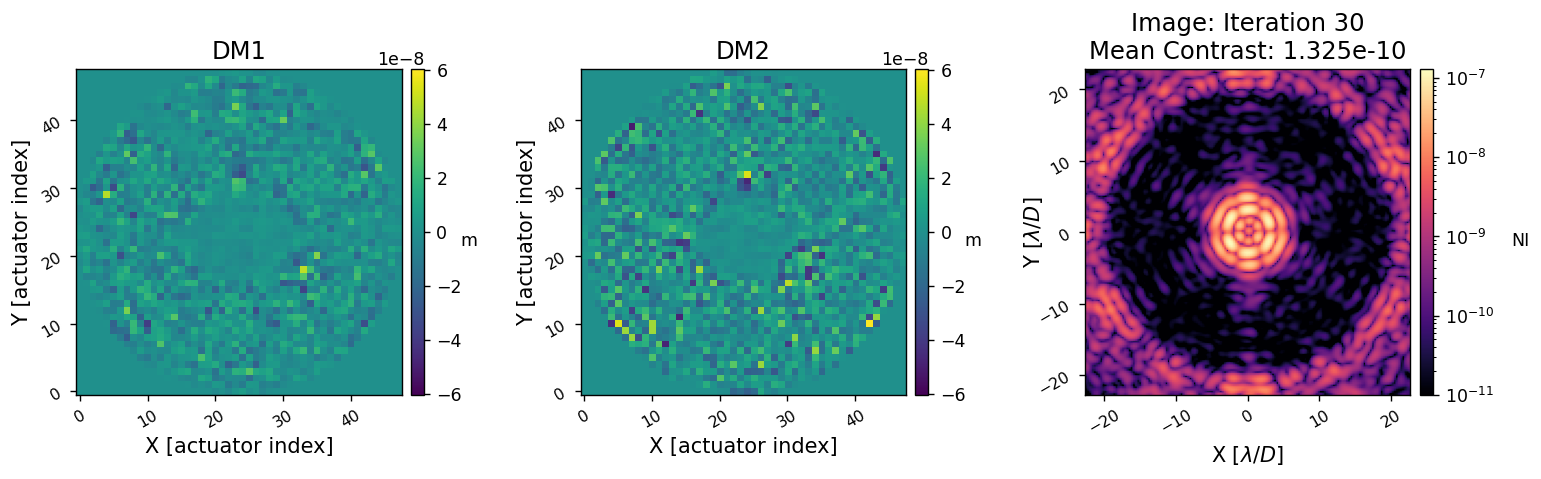

In [13]:
date = 20230925
date = 20231016
date = 20240201
dm1s = fits.getdata(response_dir/f'spc_wfov_825_had_dm1_commands_perturbed_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_had_dm2_commands_perturbed_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_had_images_perturbed_{date}.fits')

perturbed_contrast = np.mean(ims[:,ensure_np_array(control_mask)], axis=1)

i = np.argmin(perturbed_contrast)
print(perturbed_contrast[i])

dm_max = np.max(np.abs(np.concatenate([dm1s[i]-2*dm1_flat, dm2s[i]])))
dm1_rms = np.sqrt(np.mean(dm1s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm2_rms = np.sqrt(np.mean(dm2s[i][mode.dm_mask.astype(bool)]**2))*1e9
dm1_p2v = (np.max(dm1s[i]) - np.min(dm1s[i]))*1e9
dm2_p2v = (np.max(dm2s[i]) - np.min(dm2s[i]))*1e9
fig, ax = imshow3(dm1s[i]-2*dm1_flat, dm2s[i], ims[i], 
        f'DM1', 
        f'DM2',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        # xlabel1='X [actuator index]', xlabel2=' X [actuator index]', xlabel3='X [$\lambda/D$]', 
        pxscl3=mode.psf_pixelscale_lamD,
        vmin1=-dm_max, vmax1=dm_max, vmin2=-dm_max, vmax2=dm_max, 
        lognorm3=True, vmin3=1e-11, 
        wspace=0.45,
        display_fig=False, return_fig=True)
ax[0].set_title('DM1', fontsize=14)
ax[1].set_title('DM2', fontsize=14)
ax[2].set_title(f'Image: Iteration {i}\nMean Contrast: {perturbed_contrast[i]:.3e}', fontsize=14)
ax[0].set_ylabel('Y [actuator index]', fontsize=12)
ax[1].set_ylabel('Y [actuator index]', fontsize=12)
ax[2].set_ylabel('Y [$\lambda/D$]', labelpad=-5, fontsize=12)
ax[0].set_xlabel('X [actuator index]', fontsize=12)
ax[1].set_xlabel('X [actuator index]', fontsize=12)
ax[2].set_xlabel('X [$\lambda/D$]', fontsize=12)
fig.savefig('figs/iefc_perturbed_best_image.pdf', format='pdf', bbox_inches="tight")
display(fig)

# Narrowband and broadband plots

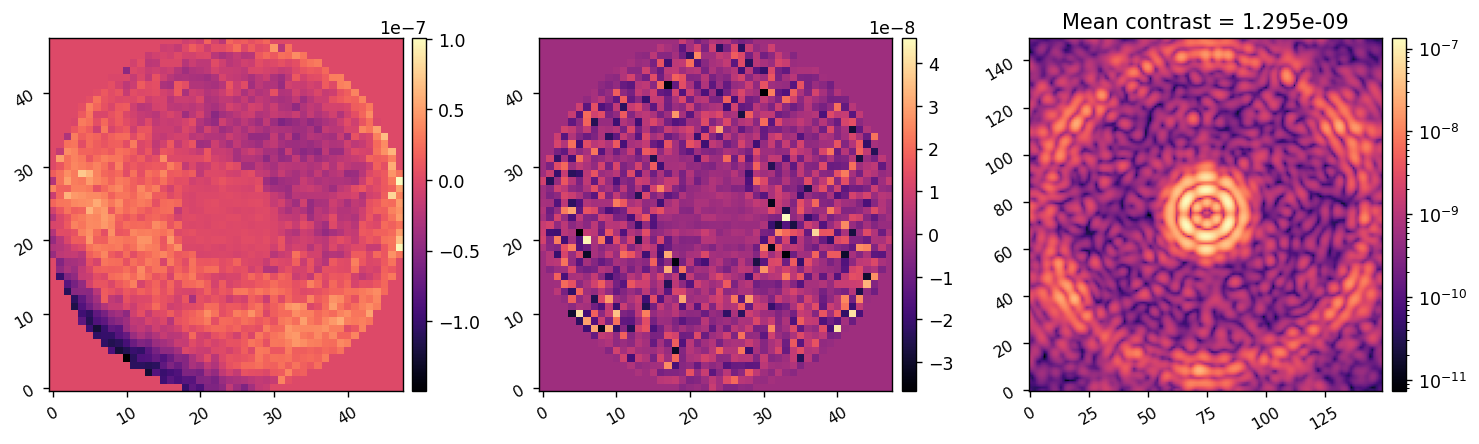

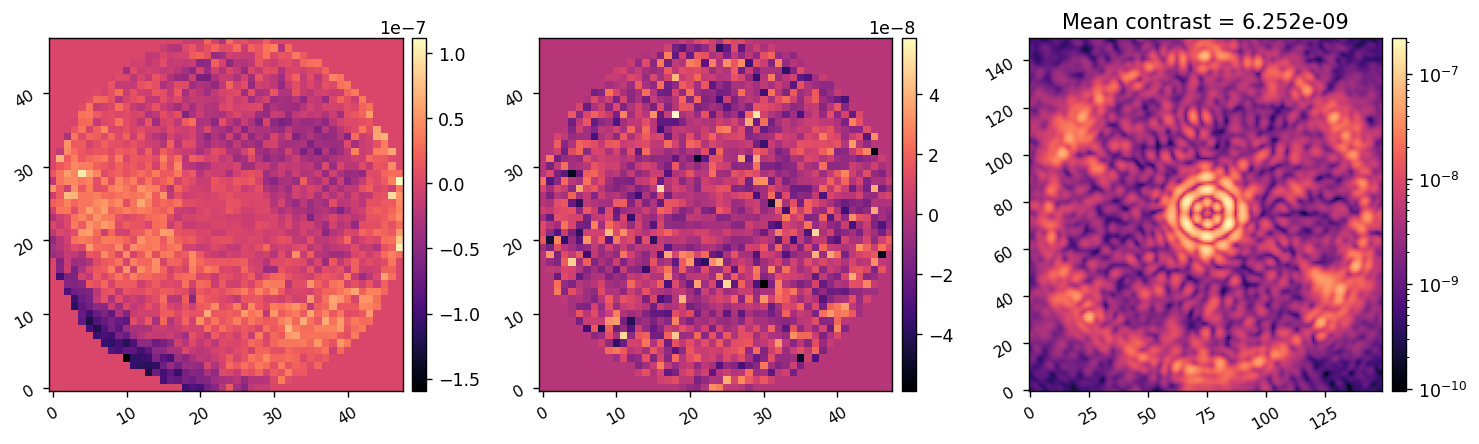

In [17]:
date = 20240214
dm1_commands_36per = xp.array(fits.getdata(response_dir/f'spc_wfov_band4b_15_dm1_commands_{date}.fits'))
dm2_commands_36per = xp.array(fits.getdata(response_dir/f'spc_wfov_band4b_15_dm2_commands_{date}.fits'))
images_36per = xp.array(fits.getdata(response_dir/f'spc_wfov_band4b_15_images_{date}.fits'))
regs_per = fits.getdata(response_dir/f'spc_wfov_band4b_15_regs_{date}.fits')

mean_ni_36per = []
for i in range(len(images_36per)):
        mean_ni_36per.append(np.mean(ensure_np_array(images_36per[i][control_mask])))

imshow3(dm1_commands_36per[-1], dm2_commands_36per[-1], images_36per[-1], 
        '', '', f'Mean contrast = {mean_ni_36per[-1]:.3e}', 
        lognorm3=True)

date = 20240212
dm1_commands_10per = xp.array(fits.getdata(response_dir/f'spc_wfov_band4_15_dm1_commands_{date}.fits'))
dm2_commands_10per = xp.array(fits.getdata(response_dir/f'spc_wfov_band4_15_dm2_commands_{date}.fits'))
images_10per = xp.array(fits.getdata(response_dir/f'spc_wfov_band4_15_images_{date}.fits'))
regs_10per = fits.getdata(response_dir/f'spc_wfov_band4_15_regs_{date}.fits')

mean_ni_10per = []
for i in range(len(images_10per)):
        mean_ni_10per.append(np.mean(ensure_np_array(images_10per[i][control_mask])))

imshow3(dm1_commands_10per[-1], dm2_commands_10per[-1], images_10per[-1], 
        '', '', f'Mean contrast = {mean_ni_10per[-1]:.3e}', 
        lognorm3=True)


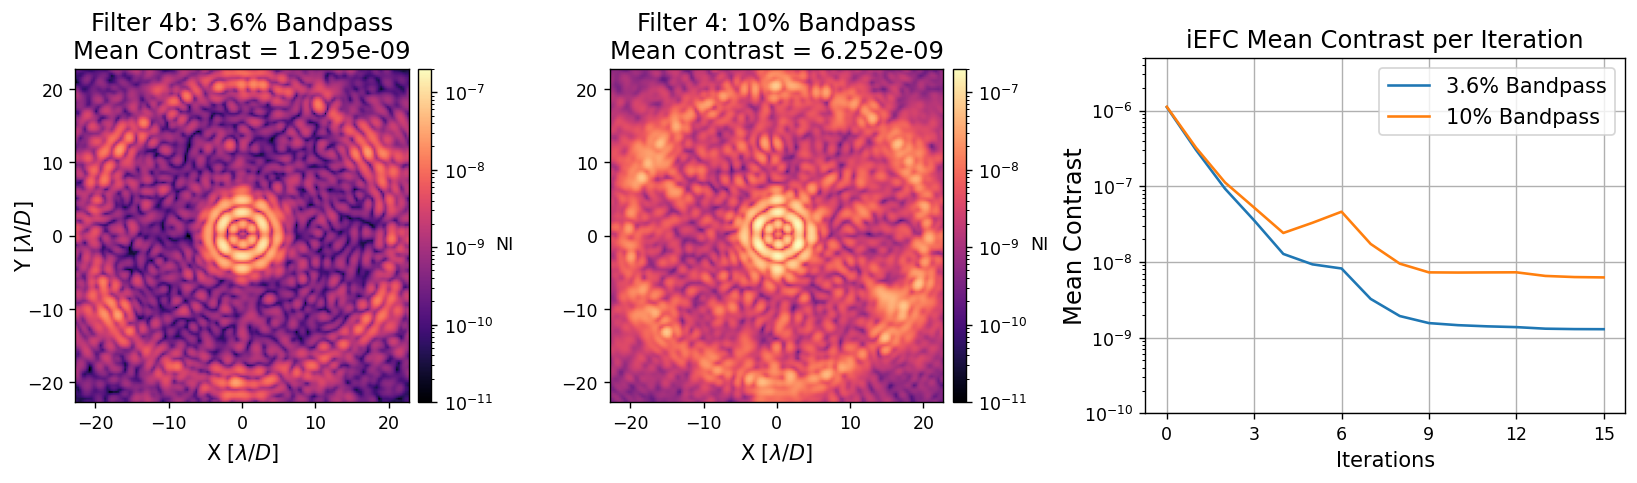

In [60]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=125, gridspec_kw={'width_ratios': [1, 1, 1.35], })
ext = mode.psf_pixelscale_lamD*150/2
extent = [-ext, ext, -ext, ext]

im1 = ax[0].imshow(ensure_np_array(images_36per[-1]), norm=LogNorm(vmax=2e-7, vmin=1e-11), cmap='magma', extent=extent)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)
ax[0].set_title(f'Filter 4b: 3.6% Bandpass\nMean Contrast = {mean_ni_36per[-1]:.3e}', fontsize=14)

im2 = ax[1].imshow( ensure_np_array(images_10per[-1]), norm=LogNorm(vmax=2e-7, vmin=1e-11), cmap='magma', extent=extent)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im2, cax=cax,)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)
ax[1].set_title(f'Filter 4: 10% Bandpass\nMean contrast = {mean_ni_10per[-1]:.3e}', fontsize=14)

ax[0].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[0].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)
# ax[1].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[1].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)

itrs = range(16)

ax[2].set_title('iEFC Mean Contrast per Iteration', fontsize=14)
ax[2].semilogy(itrs, mean_ni_36per, label='3.6% Bandpass')
ax[2].semilogy(itrs, mean_ni_10per, label='10% Bandpass')
ax[2].grid()
ax[2].set_xlabel('Iterations', fontsize=12, )
ax[2].set_ylabel('Mean Contrast', fontsize=14, labelpad=-2)
ax[2].set_ylim([1e-10, 5e-6])
ax[2].set_xticks(np.arange(0,15+1, 3))
ax[2].legend(loc='upper right', fontsize=12)
ratio = 1/2
x_left, x_right = ax[2].get_xlim()
y_low, y_high = ax[2].get_ylim()
ax[2].set_aspect(2.6)

plt.subplots_adjust(wspace=0.45)
fig.savefig('figs/iefc_bb_plots.pdf', format='pdf', bbox_inches="tight")

# Noise Simulation Plots

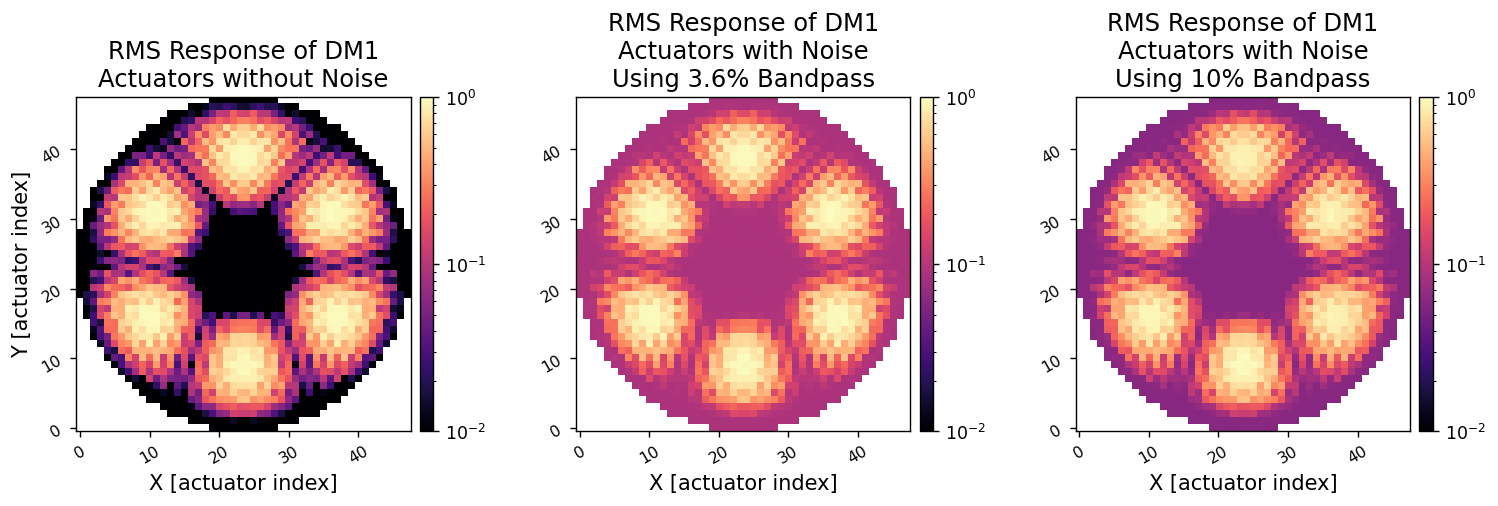

In [61]:
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)

date = 20240129
rm_noiseless = xp.array(fits.getdata(response_dir/f'spc_wide_825_had_modes_response_matrix_{date}.fits'))

date = 20240201
rm_noisy_36 = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits'))

date = 20240212
rm_noisy_10 = xp.array(fits.getdata(response_dir/f'spc_wide_band4_emccd_response_matrix_{date}.fits'))

dm1_modal_rms = xp.sqrt(xp.mean(rm_noiseless.dot(xp.array(calib_modes))**2, axis=0))[:mode.Nact**2]
dm1_act_rms = dm1_modal_rms[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm1_modal_rms.max()

dm1_modal_rms = xp.sqrt(xp.mean(rm_noisy_36.dot(xp.array(calib_modes))**2, axis=0))[:mode.Nact**2]
dm1_act_rms_noisy_36 = dm1_modal_rms[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm1_modal_rms.max()

dm1_modal_rms = xp.sqrt(xp.mean(rm_noisy_10.dot(xp.array(calib_modes))**2, axis=0))[:mode.Nact**2]
dm1_act_rms_noisy_10 = dm1_modal_rms[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm1_modal_rms.max()

# print(dm_response.max())
fig,ax = imshow3(dm1_act_rms, dm1_act_rms_noisy_36, dm1_act_rms_noisy_10,
        lognorm=True, vmax1=1, vmax2=1, vmax3=1, vmin1=0.01, vmin2=0.01, vmin3 = 0.01, 
        return_fig=True, display_fig=False,
        wspace=0.4,
        )
ax[0].set_title('RMS Response of DM1\nActuators without Noise', fontsize=14)
ax[1].set_title('RMS Response of DM1\nActuators with Noise\nUsing 3.6% Bandpass', fontsize=14)
ax[2].set_title('RMS Response of DM1\nActuators with Noise\nUsing 10% Bandpass', fontsize=14)
ax[0].set_ylabel('Y [actuator index]', fontsize=12)
ax[0].set_xlabel('X [actuator index]', fontsize=12)
ax[1].set_xlabel('X [actuator index]', fontsize=12)
ax[2].set_xlabel('X [actuator index]', fontsize=12)
fig.savefig('figs/rms_responses.pdf', format='pdf', bbox_inches="tight")
display(fig)

In [62]:
date = 20240202
images_36per_emccd = xp.array(fits.getdata(response_dir/f'spc_wfov_band4b_emccd_images_{date}.fits'))

mean_ni_36per_emccd = []
for i in range(len(images_36per_emccd)):
        mean_ni_36per_emccd.append(np.mean(ensure_np_array(images_36per_emccd[i][control_mask])))

date = 20240213
images_10per_emccd = xp.array(fits.getdata(response_dir/f'spc_wfov_band4_emccd_images_{date}.fits'))

mean_ni_10per_emccd = []
for i in range(len(images_10per_emccd)):
        mean_ni_10per_emccd.append(np.mean(ensure_np_array(images_10per_emccd[i][control_mask])))


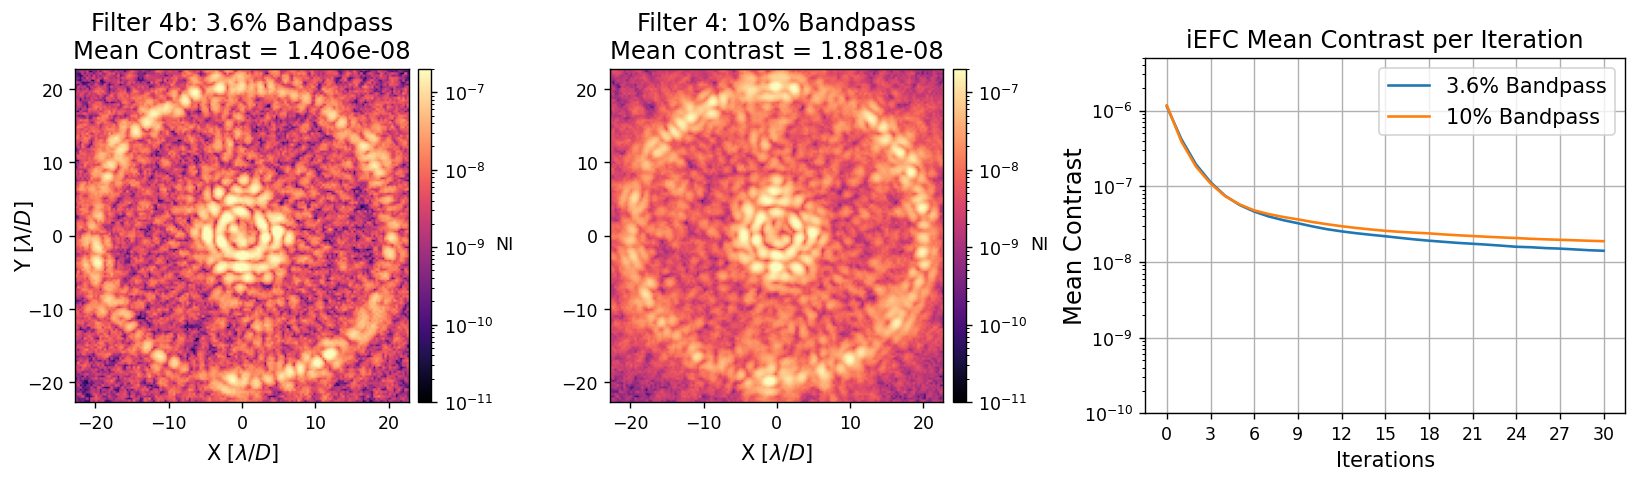

In [68]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8), dpi=125, gridspec_kw={'width_ratios': [1, 1, 1.35], })
ext = mode.psf_pixelscale_lamD*150/2
extent = [-ext, ext, -ext, ext]

im1 = ax[0].imshow(ensure_np_array(images_36per_emccd[-1]), norm=LogNorm(vmax=2e-7, vmin=1e-11), cmap='magma', extent=extent)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im1, cax=cax)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)
ax[0].set_title(f'Filter 4b: 3.6% Bandpass\nMean Contrast = {mean_ni_36per_emccd[-1]:.3e}', fontsize=14)

im2 = ax[1].imshow( ensure_np_array(images_10per_emccd[-1]), norm=LogNorm(vmax=2e-7, vmin=1e-11), cmap='magma', extent=extent)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im2, cax=cax,)
cbar.ax.set_ylabel('NI', rotation=0, labelpad=7)
ax[1].set_title(f'Filter 4: 10% Bandpass\nMean contrast = {mean_ni_10per_emccd[-1]:.3e}', fontsize=14)

ax[0].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[0].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)
# ax[1].set_ylabel('Y [$\lambda/D$]', fontsize=12, labelpad=-5)
ax[1].set_xlabel('X [$\lambda/D$]', fontsize=12, labelpad=5)

itrs = range(31)

ax[2].set_title('iEFC Mean Contrast per Iteration', fontsize=14)
ax[2].semilogy(itrs, mean_ni_36per_emccd, label='3.6% Bandpass')
ax[2].semilogy(itrs, mean_ni_10per_emccd, label='10% Bandpass')
ax[2].grid()
ax[2].set_xlabel('Iterations', fontsize=12, )
ax[2].set_ylabel('Mean Contrast', fontsize=14, labelpad=-2)
ax[2].set_ylim([1e-10, 5e-6])
ax[2].set_xticks(np.arange(0,30+1, 3))
ax[2].legend(loc='upper right', fontsize=12)
ratio = 1/2
x_left, x_right = ax[2].get_xlim()
y_low, y_high = ax[2].get_ylim()
ax[2].set_aspect(5.2)

plt.subplots_adjust(wspace=0.45)
fig.savefig('figs/iefc_bb_emccd_plots.pdf', format='pdf', bbox_inches="tight")

# Broadband Appendix

1.3624486320346218e-17 sr
	Flux for wavelength 7.838e-07 m: 5.094e+08 ph / (s m2)
	Flux for wavelength 7.975e-07 m: 4.856e+08 ph / (s m2)
	Flux for wavelength 8.113e-07 m: 4.632e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 4.422e+08 ph / (s m2)
	Flux for wavelength 8.388e-07 m: 4.224e+08 ph / (s m2)
	Flux for wavelength 8.525e-07 m: 4.038e+08 ph / (s m2)
	Flux for wavelength 8.663e-07 m: 3.862e+08 ph / (s m2)
Total flux: 3.113e+09 ph / (s m2)


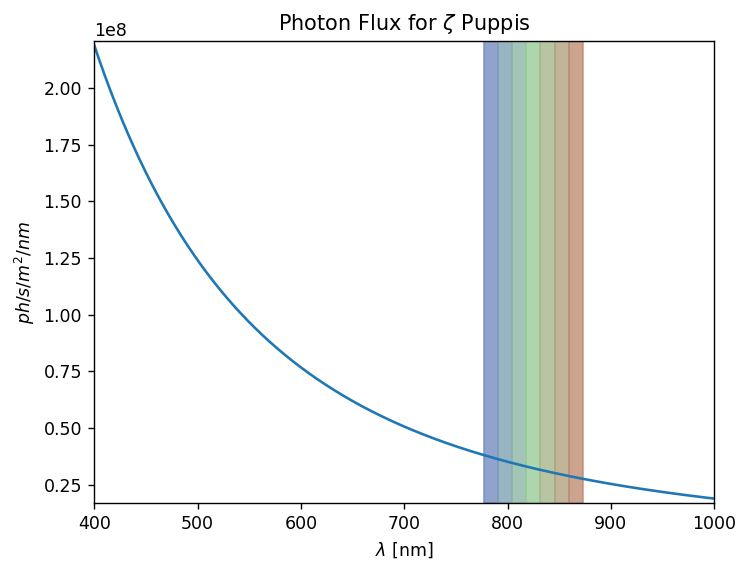

In [72]:
reload(cgi_phasec_poppy.source_flux)
wavelength_c = 825e-9*u.m

nwaves = 7
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph(save_fig='figs/zpup_blackbody_example.pdf')
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')


# Print through plots

In [ ]:
command = np.zeros((mode.Nact,mode.Nact))
command[9,23] = 1
imshow1(command)

amps = np.linspace(0, 75, 76)*1e-9

rms_vals = np.zeros(len(amps))
for i,amp in enumerate(amps):
    mode.set_dm1(amp*command)
    e1 = mode.calc_psf()
    mode.set_dm1(-amp*command)
    e2 = mode.calc_psf()

    # response = (e1-e2)/(2*amp)
    response = (e1-e2)/(2)
    rms_vals[i] = xp.sqrt(xp.mean(xp.abs(response[control_mask])**2))

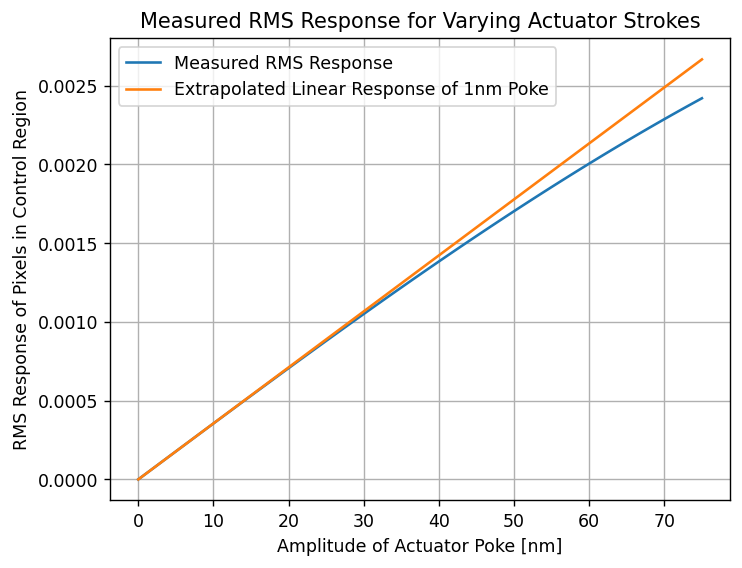

In [10]:
import matplotlib.pyplot as plt

slope = (rms_vals[1]-rms_vals[0])/(amps[1]-amps[0])

plt.figure(dpi=125)
plt.plot(amps*1e9, rms_vals, label='Measured RMS Response')
plt.plot(amps*1e9, slope*amps, label='Extrapolated Linear Response of 1nm Poke')
plt.grid()
plt.legend()
plt.title('Measured RMS Response for Varying Actuator Strokes')
plt.xlabel('Amplitude of Actuator Poke [nm]')
plt.ylabel('RMS Response of Pixels in Control Region')
plt.savefig('figs/nonlinear_response.pdf', format='pdf', bbox_inches="tight")

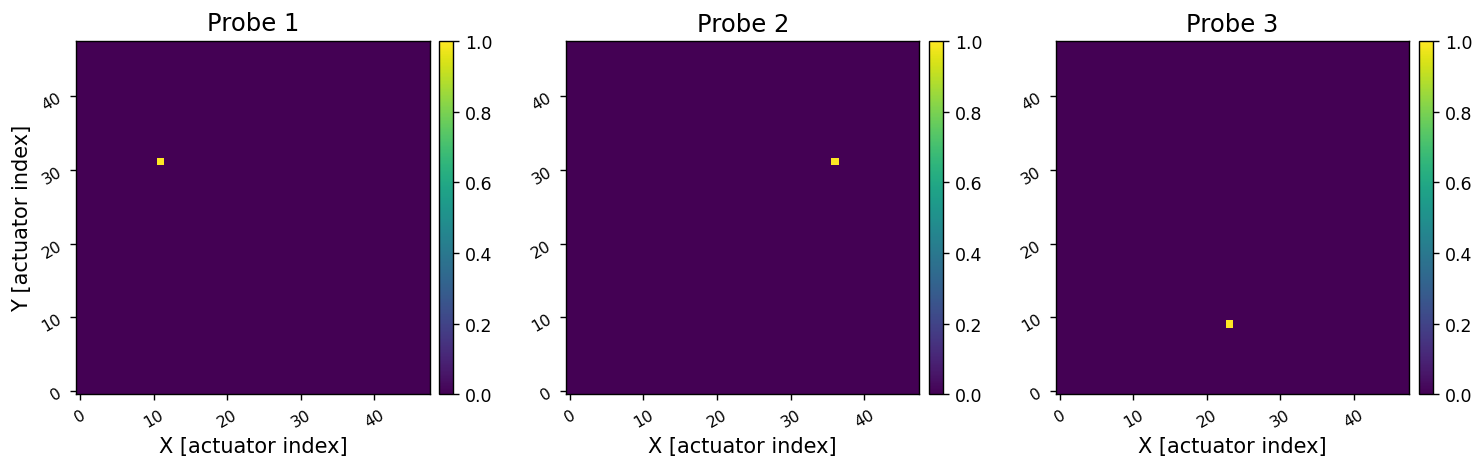

In [5]:
probe_modes = utils.create_poke_probes([(11,31), (36,31), (23,9)])
fig,ax = imshow3(probe_modes[0], probe_modes[1], probe_modes[2], 
                 'Probe 1', 'Probe 2', 'Probe 3',
                 cmap1='viridis', cmap2='viridis', cmap3='viridis',
                 display_fig=False, return_fig=True)
ax[0].set_title('Probe 1', fontsize=14)
ax[1].set_title('Probe 2', fontsize=14)
ax[2].set_title('Probe 3', fontsize=14)
ax[0].set_ylabel('Y [actuator index]', fontsize=12)
ax[0].set_xlabel('X [actuator index]', fontsize=12)
ax[1].set_xlabel('X [actuator index]', fontsize=12)
ax[2].set_xlabel('X [actuator index]', fontsize=12)
fig.savefig('figs/poke_probes.pdf', format='pdf', bbox_inches="tight")
display(fig)